<a href="https://colab.research.google.com/github/lcipolina/Amsterdan_RL_School/blob/main/Complete_DNN_2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font size="8" color="darkgreen"> Tutorial 2 Part II: </font>

# <font size="7" color="darkgreen"> Physics inspired Machine Learning</font>
<font size="7"> <i>  Partial Differential Equation (PDE) Solvers</i></font>



Before we start the tutorial a few practical things:

Create a **copy** of the notebook:
> Click on 'File' --> 'Save a copy in Drive' --> open in new tab
> Continue the tutorial with your personal copy of the notebook


Alternatively run **locally** (*or skip this step*):
> You can also of course download the notebook and run on your local pc (but then the training of the model might take longer if you don't have a gpu). Click on 'File' --> Download --> Download .ipynb

 - python version: Python 3.7.13
1.  Create a virtual env: python -m venv dl2
2. Activate the env: source dl2/bin/activate (valid for mac users, for windows see: [info](https://www.educative.io/edpresso/how-to-activate-virtualenv-windows))
3. Upgrade pip: pip install --upgrade pip
4. Install python packages: pip install -r requirements.txt (find it in the drive link, see below). Install pytroch following [pytorch](https://pytorch.org/))
5. Install juyter kernel: pip install ipykernel
6. ipython kernel install --user --name=dl2
7. Select the kernel in your jupter notebook

*disclaimer: if you ran into package issues, we recommend just running in colab*

Select the GPU option:
> 'Runtime' --> 'Change runntime type' --> Hardware accelerator: GPU

Pull this github repo for the images and a trained neural PDE solver:

In [ ]:
#!rm -rf DL2_Tutorial2 #run if you need to remove the old pull
!git clone https://github.com/IlzeAmandaA/DL2_Tutorial2.git

Cloning into 'DL2_Tutorial2'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 42 (delta 9), reused 27 (delta 2), pack-reused 0
Unpacking objects: 100% (42/42), done.


> Later in this tutorial we will use datasets to train our own Neural PDE Solver. It takes a little bit of time for the datasets to be uploaded, so let's do that first! (So by the time you get to the coding part the data is already in your environment)

- Go to: [drive](https://drive.google.com/drive/folders/1EzqazGZMBKriE45cOvY0wFLCheLQQa6G?usp=sharing)

- Download the 3 datasets on your local machine (click on 'Download anyway' when prompted second time)

- Upload them here: click on 'Files' --> right click 'Upload' (click 'ok' on the prompt)



## <font size="6" color="darkblue">PDE vs ODE: What are PDEs? </font>


A **partial derivative** of a function (with several variables) is a derivative with respect to one of its variables while the other variables are held constant.

For example take the Heat equation (1 dimension):

$$
\frac{\delta T}{\delta t}(x,t)=\frac{\delta^{2}T}{\delta x^{2}}(x,t)
$$

Here we have one partial derivative w.r.t time (left hand side, LHS), and another partial derivative w.r.t to space (right hand side, RHS), as our function T(x,t) has 2 variables. On the LHS variable $x$ is held constant, while on the RHS variable $t$ is held constant.

In particular, the above PDE describes how the temperature T(x,t) changes in time for a 1 dimensional object, such as a metal rod. If we look at the PDE equation above it says that the *rate of change of temperature in time* is the same as the *the second order derivate of the spatial domain*.  

This makes sense as the second order derivate gives you a measure of how a value compares to the average of its neighbours. For example, if the neighbors of a given point $x_{i}$ are very cold compared to the point itself then the rate of change in temperature in time for this point will be *faster*.

In the image below we have visualized the partial derivatives of the 1d Heat equation. We can investigate the rate of change of the temperature in two domains: spatial (*see Fig 1*) and time (*see Fig 2*).
(credits: 3Blue1Brwon series [source](https://https://www.youtube.com/watch?v=ly4S0oi3Yz8&t=790s))

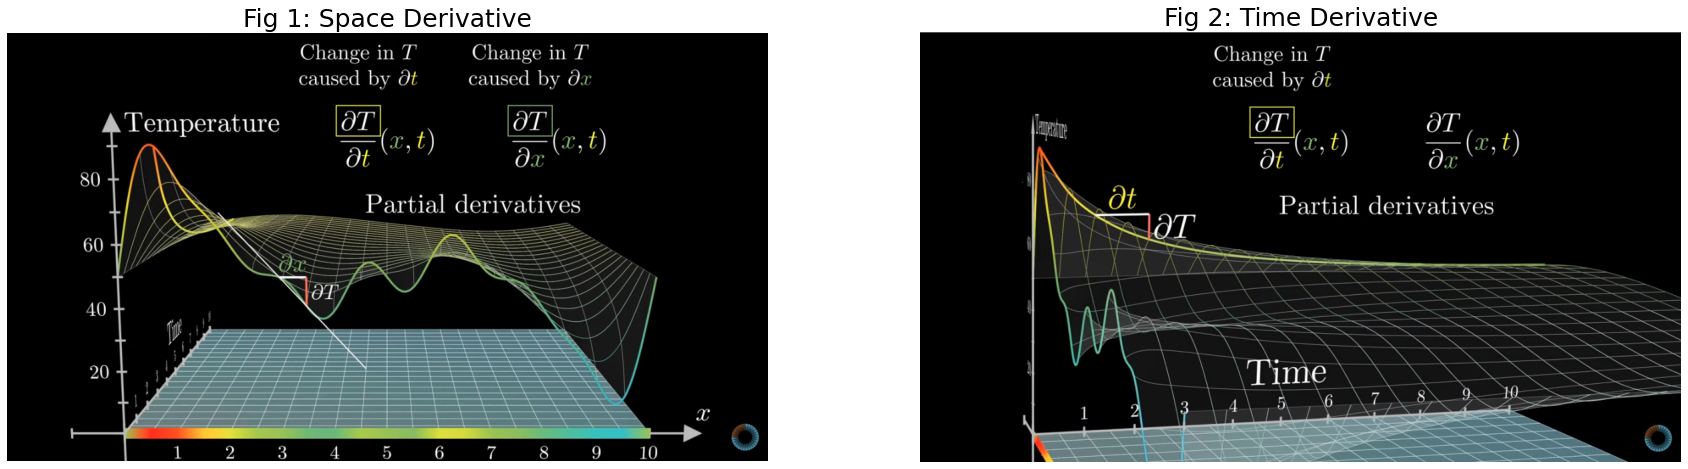

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_space = mpimg.imread('/content/DL2_Tutorial2/images/SpaceDerivative.png')
img_time= mpimg.imread('/content/DL2_Tutorial2/images/TimeDerivative.png')
f, axarr = plt.subplots(1,2, figsize=(30,30))
axarr[0].set_axis_off()
axarr[0].set_title('Fig 1: Space Derivative', fontsize=25)
axarr[1].set_axis_off()
axarr[1].set_title('Fig 2: Time Derivative', fontsize=25)
axarr[0].imshow(img_space)
axarr[1].imshow(img_time);



As you can see above each of the derivatives tells only a part of the story on how the function changes, therefore we call them partial derivates. In principle, PDEs could be seen as a system of ordinary differential equations.

In **dynamical systems** compared to traditional ML we are most interested in how our function T(x,t) changes over time. The above 1D Heat equation can be also extended to more spatial directions by extending the right hand side:


$$
\frac{\delta T}{\delta t}(x,y,z,t) = \alpha * (\frac{\delta^{2}T}{\delta x^{2}}(x,y,z, t) + \frac{\delta^{2}T}{\delta y^{2}}(x,y,z, t) + \frac{\delta^{2}T}{\delta z^{2}}(x,y,z, t))
$$


**Why do we care about PDEs?**

Thay allow us to model (predict) real life systems that influence our life:
- economics: [Black-Scholes equation](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_equation) that governs price evolution
- climate: [Wheather prediction](https://en.wikipedia.org/wiki/Numerical_weather_prediction), think about how your google weather app knows what's the weather going to be like tomorrow
- in general, the entire physical world around us


**To conclude**:

*PDEs tells us how a function with several variables changes over time. Most of the physical world is governed by PDEs.*

## <font size="6" color="darkblue">How to solve PDEs?</font>

Let's now shift our focus on a specfic PDE, for example, the **Korteweg-de Vries** ([KdV](https://mathworld.wolfram.com/Korteweg-deVriesEquation.html)) equation.


The KdV euqation (1985) is a model of shallow water waves:

![ChessUrl](https://upload.wikimedia.org/wikipedia/commons/7/7b/KdV_equation.gif "kdv")

In the above x again represents a spatial location, U(x) is the value of x given a function U, and we can see the evolution of the system in time.

The PDE equation governing the above simulation is:

$$
\frac{\delta U}{\delta t}(x,t) = - U(x,t) * \frac{\delta U}{\delta x}(x,t) - \frac{\delta^{3}U}{\delta x^{3}}(x,t)
$$

Similar to the heat equation in the introduction our function U has two dimentions, x and t, where x is the spatial domain and t is the time domain. The $\frac{\delta^{3}U}{\delta x^{3}}(x,t)$ is a [dispersive term](https://en.wikipedia.org/wiki/Dispersion_(water_waves)) and $U(x,t) * \frac{\delta U}{\delta x}(x,t)$ is a non-linear [convection term ](https://en.wikipedia.org/wiki/Convection).

When we are taking about solving a PDE what we want to do is to find a function U(x,t) that would:
- satisfy the above given PDE
- meet the boundary conditions
- meet the initial conditions


These additional constraints, boundary and inital conditions, restrict the function U(x,t) that is valid for the given PDE equation

**Boundary Conditions**

The boundary conditions express the behaviour of a function on the boundary (border) of its area of definitions.
For example, you constrain that at both ends of the spatial domain $x_{0}$ and $x_{L}$ (where L is the end of your spatial domain) the function remains constant for all time:
$$
\frac{\delta U}{\delta x}(x_{0},t)=\frac{\delta U}{\delta x}(x_{L},t)=0
 $$
 $$ \forall t
 $$

**Initial Conditions**

An initial condition is similar to boundary conditions, but now in the time direction. For example, now you constrain what value your function U(x,t) must return at timepoint t=0. For the KdV simulation above the initial condition was:

$U(x,0) = cos(\pi x)$
$\forall x$



**Solving PDE**

Similary to ODEs the traditional way of solving a given PDE equation is via *numerical solvers*.

In the below cells we will implement a simple numerical solver in order to solve the above KdV equation

### Numerical Solvers

In [ ]:
#Import relevant packages
%matplotlib inline
import matplotlib
from matplotlib.pyplot import cm
import numpy as np
from typing import Optional
from scipy.integrate import solve_ivp
from scipy.fftpack import diff as psdiff

from matplotlib import animation
import seaborn as sns
from IPython.display import HTML

#### Generate Initial Conditions

Initial conditions are sampled from a distribution over truncated Fourier series with random coefficients
$\{A_k, \ell_k, \phi_k\}_k$ as
$$
    U(x,0) = \sum_{k=1}^N A_k \sin(2 \pi \ell_k x / L + \phi_k) \ .
$$

In [ ]:
def generate_params() -> (int, np.ndarray, np.ndarray, np.ndarray):
    """
    Returns parameters for initial conditions.
    Args:
        None
    Returns:
        int: number of Fourier series terms
        np.ndarray: amplitude of different sine waves
        np.ndarray: phase shift of different sine waves
        np.ndarray: frequency of different sine waves
    """
    N = 10 #Number of different waves
    lmin, lmax = 1, 3 #sine frequencies for intial conditions
    A = (np.random.rand(1, N) - 0.5)
    phi = 2.0*np.pi*np.random.rand(1, N)
    l = np.random.randint(lmin, lmax, (1, N))
    return (N, A, phi, l)

def initial_conditions(x: np.ndarray, L: int, params: Optional[list]=None) -> np.ndarray:
    """
    Return initial conditions based on initial parameters.
    Args:
        x (np.ndarray): input array of spatial grid
        L (float): length of the spatial domain
        params (Optinal[list]): input parameters for generating initial conditions
    Returns:
        np.ndarray: initial condition
    """
    if params is None:
        params = generate_params()
    N, A, phi, l = params
    u = np.sum(A * np.sin((2 * np.pi * l * x[:, None] / L ) + phi), -1)
    return u


#### Solve via Method of Lines (MOL)
In MOL all but the temporal dimension are discretized. Having the spatial derivatives numerically implemented results in a set of coupled ODEs for the time domain, which can be solved by using integration schemes of ODE solving.

Concretely, for getting numerical spatial derivatives, we use [pseudospectral methods](https://en.wikipedia.org/wiki/Pseudo-spectral_method), where the derivatives are computed in the frequency domain by first applying a fast fourier transform (FFT) to the data, then multiplying by the appropriate values and converting back to the spatial domain with the inverse FFT.

Mathematically this works since the Fourier transform of the $n$th derivative is given by:
$$
\displaystyle \widehat{f^{(n)}} (\xi) = \mathcal{F} \bigg( \frac{d^n}{dx^n} f(x) \bigg) = (2\pi i \xi)^n \widehat{f}(\xi) \ ,
$$
where $\displaystyle \widehat{f^{(n)}}$ is the mathematical denotation of fourier transform of a function $f$, the transform variable $\xi$ represents frequency, $f(x)$ is an absolutely continuous differentiable function, and both $f$ and its derivative $f′$ are integrable (for more information see [wikipedia](https://en.wikipedia.org/wiki/Fourier_transform#Tables_of_important_Fourier_transforms) section Functional relations). This method of differentiation in the Fourier space is implemented by the `diff` function in the module `scipy.fftpack`.
For integration in time we use an **implicit Runge-Kutta method** of Radau IIA family, order 5.

In [ ]:
# Spatial Derivatives
def kdv_pseudospectral(t: float, u: np.ndarray, L: float) -> np.ndarray:
    """
    Compute spatial derivatives for the KdV equation, using a pseudospectral method, descretization in x.
    Args:
        t (float): time point
        u (np.ndarray): 1D input field
        L (float): length of the spatial domain
    Returns:
        np.ndarray: reconstructed pseudospectral time derivative
    """
    # Compute the x derivatives using the pseudo-spectral method.
    ux = psdiff(u, order=1, period=L)
    uxxx = psdiff(u, order=3, period=L)
    # Compute du/dt.
    dudt = -u*ux - uxxx
    return dudt


#### Solve for KdV trajectory

In [ ]:
# Set the size of the domain, and create the discretized grid.
np.random.seed(1)
L = 128
N = 2**7
x = np.linspace(0, (1-1.0/N)*L, N)

# Set the tolerance of the solver
tol = 1e-6

# Set the initial conditions.
u0 = initial_conditions(x, L)

# Set the time sample grid.
T = 100.
t = np.linspace(0, T, 200)

# Compute the solution using kdv_pseudospectral as spatial solver
sol_ps = solve_ivp(fun=kdv_pseudospectral,
                               t_span=[t[0], t[-1]],
                               y0=u0,
                               method='Radau',
                               t_eval=t,
                               args=(L,),
                               atol=tol,
                               rtol=tol)

#### Visualize the solved KdV

Let's first plot our initial state:

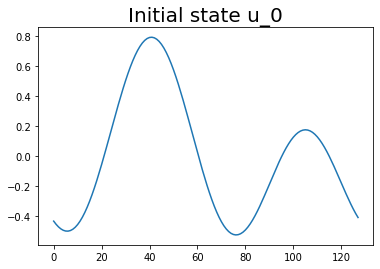

In [ ]:
plt.plot(u0)
plt.title('Initial state u_0', fontsize=20)
plt.show();

Time as y axis, spatial domain as x axis, function value U(x,t) as colorbar

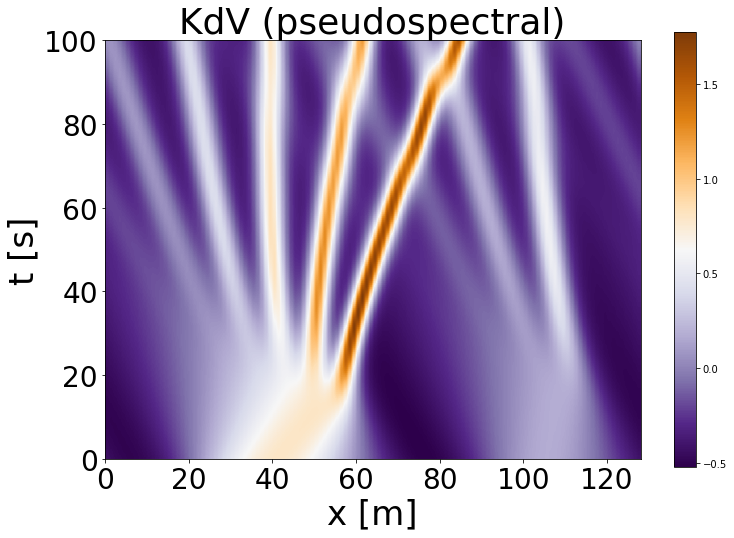

In [ ]:
# Let's look at the trajectory obtained by using the pseudospectral spatial solver
if sol_ps.success:
    t_ps = sol_ps.y.T[::-1]
    plt.figure(figsize=(12,8))
    plt.imshow(t_ps, extent=[0,L,0,T], cmap='PuOr_r')
    plt.colorbar()
    plt.title('KdV (pseudospectral)', fontsize=36)
    plt.xlabel('x [m]', fontsize=34)
    plt.ylabel('t [s]', fontsize=34)
    plt.yticks(fontsize=28)
    plt.xticks(fontsize=28)
    plt.show()

In the figure above we can see the time evolution of our initial state $U(x,t_{0})$. As we only have one spatial domain, each $x$ point is a coordinate in our spatial domain, for example, the bottom left point would be the value of $U(x_{0},t_{0})$. The color indicates the value of our function $U(.)$, and the more brown the color the *higher* the wave. Interpret the *stripes* you see as waves and as time progresses the waves get sharper.

Feel free to play around with the settings under *generate_params()* and see how the simulation changes!

Let's create our own animation!

In [ ]:
plt.rcParams["animation.html"] = "jshtml"

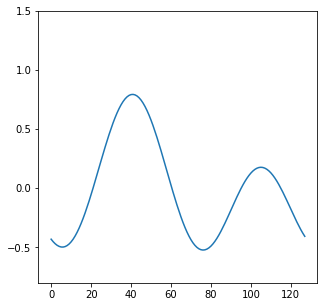

In [ ]:
t_ps_anim = np.flipud(t_ps)
fig, ax = plt.subplots(figsize=(5,5))

def animate(t):
    plt.cla()
    plt.ylim([-0.8, 1.5])
    plt.plot(t_ps_anim[t,:])

matplotlib.animation.FuncAnimation(fig, animate, frames=200, interval=20)

In the animation, on the y-axis we have the output of the function, $U(x,t)$. As the animcation plays we can see the waves of our initial state to become more peaked.

**Why do we care about Numerical Solvers?**

This story is two-fold:
- We need numerical solvers to generate data to train our ML models
- Numerical solvers have higher accuracy than NN, hence, they provide a baseline for expected acuraccy for a given PDE

And in general the field of numerical solvers is about 100 years old, definitely there are things that we can learn from them!

## <font size="6" color="darkblue"> Neural Networks as PDE Solvers</font>

The initial interest of why we would want to replace traditional numerical solvers with deep learning is because traditional PDE solvers, such as finite element methods and finite difference methods, rely on discretizing the space into a very fine mesh. As a result traditional solvers have the following drawbacks:
- The error scales steeply with the resolution. We need a high resolution to get good approximations.
- The computation and storage steeply scale with the resolution (i.e. the size of the grid).
- When the equation is solved on one discretization, we cannot change the discretization anymore.

So the question is: *can we use neural networks to improve upon the drawbakcs of numerical solvers?*

> In short, the answer is **yes** and in the upcoming section we will explore on how to construct such a network.



### What is our network's aim?

What we would like our deep neural network to do is that given our initial and/or boundary conditions to directly output the solution, similar to image-to-image mapping. See below, we have an initial state *Initial Vorticity* and we want to predict the *'image'* at $t_{15}$.


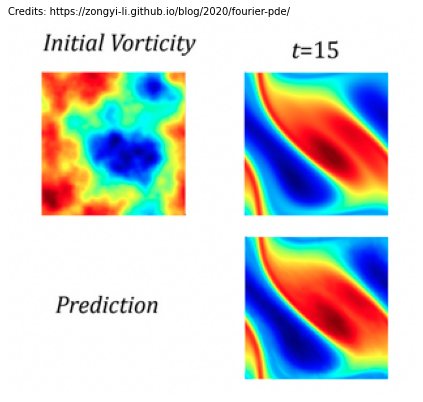

In [ ]:
img_pde = mpimg.imread('/content/DL2_Tutorial2/images/PDEimg-img.png')
caption = "Credits: https://zongyi-li.github.io/blog/2020/fourier-pde/"
plt.figure(figsize=(10, 7))
plt.imshow(img_pde)
plt.text(0, 0, caption, ha='left', fontsize=10)
plt.axis('off');

 However, when we talk about PDEs we consider our input and output space to be **functions**. What we mean by this is that we have some initial function $U$ that takes as input $x$, $y$ and $t$, $U(x,y,t_{0})$ respectively. In the above image that would be the *Initial Vorticity* state. We want our model to output perhaps the resulting function 15 time steps later $A(x,y,t_{15})$, so the state to the right. As such, **images could be considered as functions**. In the context of standard ML an image is a function of light defined on a continous region, instead of 32x32 pixel vectors.

Hence, we want our neural network, $G$ (parameterised by $\theta$) to map between function spaces:

$$
G_{\theta} : U ⟶ A
$$

In order to do so let me introduce to you the concept of **neural operators**.


### Neural Operators

Let's break down this term "**Neural Operators (NO)**" in 2 parts: (i) neural and (ii) operator. With the first one you probably already are familiar, so let's start with the second one.

#### Operator

The term [operator](https://en.wikipedia.org/wiki/Operator_(mathematics)) comes from mathematics:

> *an operator is generally a mapping or function that acts on elements of a space to produce elements of another space*

Indeed, that is exactly what he have defined as the goal of our NN.

So what is the benefit of rephrasing the img-to-img problem to func-to-func? **Generalizability**.


> The neural operator is **mesh-independent**, this is different from standard ML methods such as CNNs. The func-to-func mapping perspective allow us to: (i) first use a numerical solver to generate some low-resolution data, (ii) then train a neural operator on this data, (iii) but now the learned NO is able to give also high-resolution predictions, despite being trained on low-resolution data. This makes both, the training and the evaluation, easier.

In short: the benefit of operator persepctive is that now we are parameterizing the model in function space - **it learns the continuous functions instead of discretized vectors**





#### Neural





The neural part is that just like NN: our neural operator will also consist of linear transformations, $K$, and non-linear activations, $\sigma$.

A standard deep neural network can be written as:

$$
y = (K_{l}∘σ_{l}∘⋯\sigma_{1}∘K_{0})x
$$
where $∘$ defines function composition, $y$ is the output vector, $x$ is the input vector, $K$ are linear or convolutional layers, and $\sigma$ are the activation functions such as ReLU.

As we dicussed for operators our inputs and outputs are functions, hence we need to adjust the above to neural operator framework:

$$
a(x) = (K_{l}∘σ_{l}∘⋯\sigma_{1}∘K_{0})u(x)
$$

now our output vector $y$ is replaced by a function $a$, and our input vector $x$ is replaced by a function $u$. Both functions, $u$ and $a$ are able to take inputs at different discretizations (28x28, or 256x256), hence allowing the neural operator to be discretization independent.

In order for the above to be true we need to adjust the formulation of our linear layers, $K$, as it has to be able to take functions as input. We reformulate $K$ as a kernel integral operator, changing the layer architecture to:

$$
u_{t+1}(x) = \sigma (W u_{t}(x) + (K u_{t})(x))
$$
$$
(Ku_{t})(x) := ∫k(x,y)u(y)dy
$$

where $k$ is a kernel function and $W$ is the bias term. The only question remaining is how to define the kernel itself, $k(x,y)$. Recent research has investigated multiple alternatives, however the kernel that has brought the most promising results is the **Fourier Neural Operator**.

### Fourier Neural Operator

What Li et al. (2020) proposes is to set the above kernel integral operator, $(K u_{t})(x)$, by a convolution operator defined in Fourier space. Why is this desirable?
> - it's fast: convolution in one domain (spatial domain) equals **point-wise multiplication** in the frequency domain ([convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem))
- it's efficient: the inputs and outputs of PDEs are continous functions, so it's more efficient to represent them in Fourier space.

Hence, the **Fourier Integral Operator** is:
$$
(Ku_{t})(x) = 𝐹^{-1}(R_{\phi}⋅(𝐹u_{t}))(x)
$$
where $R_{\phi}$ is the linear tranform of the lower Fourier modes. Let's break down what is happening in the above function:
- first we do a Fourier transform: $(Fu_{t})(x)$
- then a linear transform: $R \cdot ()$
- and lastly we perform an inverse fourier transform: $F^{-1}(\cdot)$

In the image below we have depicted a complete **Fourier layer** ($v(x)$ is $u(x)$ in our notation):

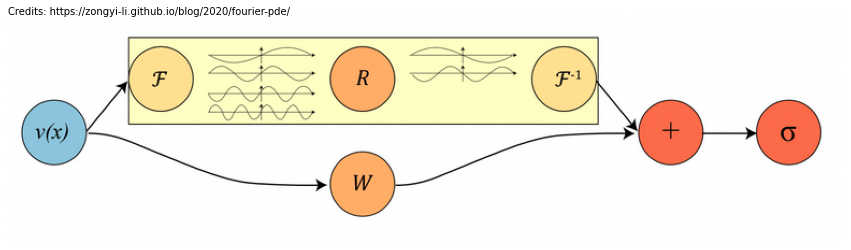

In [ ]:
img_fourier = mpimg.imread('/content/DL2_Tutorial2/images/fourierlayer.png')
caption = "Credits: https://zongyi-li.github.io/blog/2020/fourier-pde/"
plt.figure(figsize=(15, 10))
plt.imshow(img_fourier)
plt.text(0, 0, caption, ha='left', fontsize=10)
plt.axis('off');

As you can see in the above figure $R_{\phi}$ acts as a linear transformation on the lower frequency modes and sets the higher modes to zeros. Nonetheless, despite the fact that Fourier Integral Operator on it's own loses the higher frequency modes and works only with periodic boundary conditions, the operator as a whole does not suffer from this:
> The bias term helps to recover the non-periodic boundaries, and the non-linear activations help to recover the higher frequency modes. The activations act on the spatial domain, which is also the reason why we need the inverse fourier transform


**Resolution Invariance**

The Fourier layers are discretization-invariant, because they can learn from and evaluate functions which are discretized in an arbitrary way. Since parameters are learned directly in Fourier space, resolving the functions in physical space simply amounts to projecting on the basis of wave functions which are well-defined everywhere on the space. This allows us to transfer among discretization.


## <font size="6" color="darkblue"> Time to code a Neural PDE Solver</font>

We will train our Neural PDE Solver on the KdV PDE that was introduced earlier in this notebook.



#### The Data

the data is located in your runtime environment. If you click on 'Files' on the left side, you will see the downloaded files:
- KdV_train_512_easy.h5
- KdV_valid_easy.h5
- KdV_test_easy.h5

>Each dataset containts 512 trajectories. The length, L, of the spatial domain is 128, while the spatial resolution of the dataset is 256. We stimulate each trajectory for 100 time steps, with a temporal resolution of 140.

>KdV equation initial conditions are generated by the same principle as in the earlier example in the notebook

#### Fourier Intergral Operator

Let's first implement the euqation of the **Fourier Integral Operator** that we discussed in the previous section.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

In [ ]:
################################################################
#  1d Fourier Integral Operator
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, modes: int):
        super(SpectralConv1d, self).__init__()
        """
        Initializes the 1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        Args:
            in_channels (int): input channels to the FNO layer
            out_channels (int): output channels of the FNO layer
            modes (int): number of Fourier modes to multiply, at most floor(N/2) + 1
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        self.scale = (1 / (in_channels*out_channels))
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        """
        Complex multiplication of the Fourier modes.
        [batch, in_channels, x], [in_channel, out_channels, x] -> [batch, out_channels, x]
            Args:
                input (torch.Tensor): input tensor of size [batch, in_channels, x]
                weights (torch.Tensor): weight tensor of size [in_channels, out_channels, x]
            Returns:
                torch.Tensor: output tensor with shape [batch, out_channels, x]
        """
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Fourier transformation, multiplication of relevant Fourier modes, backtransformation
        Args:
            x (torch.Tensor): input to forward pass os shape [batch, in_channels, x]
        Returns:
            torch.Tensor: output of size [batch, out_channels, x]
        """
        batchsize = x.shape[0]
        # Fourier transformation
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes] = self.compl_mul1d(x_ft[:, :, :self.modes], self.weights)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


Now once we have our integral kernel, we are ready to build our neural network.

#### Overall Network Architecture

We will follow the original architecture as desribed by the [FNO paper](https://arxiv.org/abs/2010.08895). The network is constructed by stacking four Fourier layers with ReLU activations.

In addition, we will add some minor improvements as described by [LPSDA paper](https://arxiv.org/abs/2202.07643): we will predict in 'batches' (mutliple time points)

In [ ]:
################################################################
#  1d Fourier Network
################################################################
class FNO1d(nn.Module):
    def __init__(self, modes, width, time_future, time_history):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: a driving function observed at T timesteps + 1 locations (u(1, x), ..., u(T, x),  x).
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """
        self.modes = modes
        self.width = width
        self.time_future = time_future
        self.time_history = time_history
        self.fc0 = nn.Linear(self.time_history+1, self.width)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, self.time_future)

    def forward(self, u):
        grid = self.get_grid(u.shape, u.device)
        x = torch.cat((u, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)



Helper functions

In [ ]:
import h5py
import torch
from typing import Tuple
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

#function to torch dataloader from the dataset
def create_dataloader(data_string: str, mode: str, nt: int, nx: int, batch_size:int, num_workers:int):
    try:
        dataset = HDF5Dataset(data_string,mode,nt=nt,nx=nx)
        loader = DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers)
    except:
        raise Exception("Datasets could not be loaded properly")

    return loader


#Function to format the data in the correct format
def to_coords(x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """
    Transforms the coordinates to a tensor X of shape [time, space, 2].
    Args:
        x: spatial coordinates
        t: temporal coordinates
    Returns:
        torch.Tensor: X[..., 0] is the space coordinate (in 2D)
                      X[..., 1] is the time coordinate (in 2D)
    """
    x_, t_ = torch.meshgrid(x, t)
    x_, t_ = x_.T, t_.T
    return torch.stack((x_, t_), -1)

#Helper class to open the .h5 formated file
class HDF5Dataset(Dataset):
    """
    Load samples of an PDE Dataset, get items according to PDE.
    """
    def __init__(self, path: str,
                 mode: str,
                 nt: int,
                 nx: int,
                 dtype=torch.float64,
                 load_all: bool=False):
        """Initialize the dataset object.
        Args:
            path: path to dataset
            mode: [train, valid, test]
            nt: temporal resolution
            nx: spatial resolution
            shift: [fourier, linear]
            pde: PDE at hand
            dtype: floating precision of data
            load_all: load all the data into memory
        """
        super().__init__()
        f = h5py.File(path, 'r')
        self.mode = mode
        self.dtype = dtype
        self.data = f[self.mode]
        self.dataset = f'pde_{nt}-{nx}'


        if load_all:
            data = {self.dataset: self.data[self.dataset][:]}
            f.close()
            self.data = data

    def __len__(self):
        return self.data[self.dataset].shape[0]

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Returns data items for batched training/validation/testing.
        Args:
            idx: data index
        Returns:
            torch.Tensor: data trajectory used for training/validation/testing
            torch.Tensor: dx
            torch.Tensor: dt
        """
        u = self.data[self.dataset][idx]
        x = self.data['x'][idx]
        t = self.data['t'][idx]
        dx = self.data['dx'][idx]
        dt = self.data['dt'][idx]


        if self.mode == "train":
            X = to_coords(torch.tensor(x), torch.tensor(t))
            sol = (torch.tensor(u), X)

            u = sol[0]
            X = sol[1]
            dx = X[0, 1, 0] - X[0, 0, 0]
            dt = X[1, 0, 1] - X[0, 0, 1]
        else:
            u = torch.from_numpy(u)
            dx = torch.tensor([dx])
            dt = torch.tensor([dt])
        return u.float(), dx.float(), dt.float()

#function to create x - y data pairs: 20 past timepoints as x, 20 future timepoints as y
def create_data(datapoints: torch.Tensor, start_time: list, time_future: int, time_history: int) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Getting data of PDEs for training, validation and testing.
    Args:
        datapoints (torch.Tensor): trajectory input
        start_time (int list): list of different starting times for different trajectories in one batch
        pf_steps (int): push forward steps
    Returns:
        torch.Tensor: neural network input data
        torch.Tensor: neural network labels
    """
    data = torch.Tensor()
    labels = torch.Tensor()
    # Loop over batch and different starting points
    # For every starting point, we take the number of time_history points as training data
    # and the number of time future data as labels
    for (dp, start) in zip(datapoints, start_time):
        end_time = start+time_history
        d = dp[start:end_time]
        target_start_time = end_time
        target_end_time = target_start_time + time_future
        l = dp[target_start_time:target_end_time]

        data = torch.cat((data, d[None, :]), 0)
        labels = torch.cat((labels, l[None, :]), 0)

    return data, labels

### Train the Neural PDE Solver

First we will define the configurations of our experiment and create the data loader for training, validation and test data

In [ ]:
################################################################
#  configurations
################################################################

#Experiment Settings
ntrain = 512 #train samples
nt = 140 #temporal resolution
nx = 256 #spatial resoltuion
time_history = 20 #time steps to be considered as input to the solver
time_future = 20 #time steps to be considered as output of the solver
device = 'cpu'  #change to cpu of no cuda available
print_interval = 20

#model parameters
modes = 16 # number of Fourier modes to multiply
width = 64 # input and output channels to the FNO layer
batch_size = 16
num_epochs = 1 #set to one so faster computation, in principle 20 is best
learning_rate = 0.0001
lr_decay = 0.4
num_workers = 0

In [ ]:
################################################################
# read data
################################################################
train_loader = create_dataloader("/content/KdV_train_10_1_3_512_easy.h5", mode="train", nt=nt, nx=nx, batch_size=batch_size, num_workers=num_workers)
valid_loader = create_dataloader("/content/KdV_valid_10_1_3_easy.h5", mode="valid", nt=nt, nx=nx, batch_size=batch_size, num_workers=num_workers)
test_loader = create_dataloader("/content/KdV_test_10_1_3_easy.h5", mode = "test", nt=nt, nx=nx, batch_size=batch_size, num_workers=num_workers)

Initialize the model

In [ ]:
import operator
from functools import reduce
# print the number of parameters
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul,
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c

# model
model = FNO1d(modes, width, time_future, time_history).to(device)
print('Number of paramters: {}'.format(count_params(model)))

Number of paramters: 553236


Select an optimizer

*we also implement a scheduler 'MultiStepLR' that decays the learning rate, to lear more read [info](https://hasty.ai/content-hub/mp-wiki/scheduler/multisteplr)*

In [ ]:
# Optimizer
from torch import optim
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0, 5, 10, 15], gamma=lr_decay)


Select a training objective

In [ ]:
criterion = torch.nn.MSELoss(reduction="none")

Below are functions for the training and test loop

In [ ]:
import random

def bootstrap(x: torch.Tensor, Nboot: int=64, binsize: int=1) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Bootstrapping mean or median to obtain standard deviation.
    Args:
        x (torch.Tensor): input tensor, which contains all the results on the different trajectories of the set at hand
        Nboot (int): number of bootstrapping steps, 64 is quite common default value
        binsize (int):
    Returns:
        torch.Tensor: bootstrapped mean/median of input
        torch.Tensor: bootstrapped variance of input
    """
    boots = []
    x = x.reshape(-1, binsize, *x.shape[1:])
    for i in range(Nboot):
        boots.append(torch.mean(x[torch.randint(len(x), (len(x),))], axis=(0, 1)))
    return torch.tensor(boots).mean(), torch.tensor(boots).std()

def training_loop(loader,model, optimizer, criterion, device, batch_size):
  """
  Training loop.
  Loop is over the mini-batches and for every batch we pick a random timestep.
  This is done iteratively for the number of timesteps in one training sample.
  One average, we therefore start at every starting point in every trajectory during one episode.
  Args:
      model (torch.nn.Module): neural network model
      optimizer (torch.optim): chosen optimizer
      loader (DataLoader): train/valid/test dataloader
      criterion (torch.nn.modules.loss): loss criterion
      device: device (cpu/gpu)
  """
  losses = []
  max_start_time = (nt - time_history) - time_future
  for (u, _, _) in loader:
      optimizer.zero_grad()
      start_time = random.choices([t for t in range(time_history, max_start_time + 1, time_history)], k=batch_size)

      data, labels = create_data(u, start_time, time_history, time_future)
      data, labels = data.to(device), labels.to(device)

      # Change [batch, time, space] -> [batch, space, time]
      data = data.permute(0, 2, 1)

      #forward pass
      pred = model(data)

      loss = criterion(pred.permute(0, 2, 1), labels)
      loss = loss.sum()
      loss.backward()
      losses.append(loss.detach() / batch_size)
      optimizer.step()

  losses = torch.stack(losses)
  return losses

def test(loader,model,criterion, device, batch_size):
    """
    Test routine.
    Both step wise losses and enrolled forward losses are computed.
    Args:
        model (torch.nn.Module): neural network model
        loader (DataLoader): train/valid/test dataloader
        criterion (torch.nn.modules.loss): loss criterion
        device: device (cpu/gpu)
    Returns:
        (torch.Tensor, torch.Tensor, torch.Tensor, torch. Tensor): mean and normalized mean errors
        of full trajectory unrolling
    """
    losses, nlosses = [], []
    max_start_time = (nt - time_history) - time_future
    for (u, _, _) in loader:
        losses_tmp, nlosses_tmp = [], []
        with torch.no_grad():
            # the first time steps are used for data augmentation according to time translate
            # we ignore these timesteps in the testing
            for start in range(time_history, max_start_time+1, time_future):

                end_time = start + time_history
                target_end_time = end_time + time_future
                if start == time_history:
                    data = u[:, start:end_time].to(device)
                    data = data.permute(0, 2, 1)
                else:
                    data = torch.cat([data, pred], -1)
                    data = data[..., -time_history:]

                labels = u[:, end_time: target_end_time].to(device)
                pred = model(data)

                loss = criterion(pred.permute(0, 2, 1), labels)
                nlabels = torch.mean(labels ** 2, dim=-1, keepdim=True)
                nloss = loss / nlabels
                loss, nloss = loss.sum(), nloss.sum()
                loss, nloss = loss / nx / batch_size, nloss / nx / batch_size
                losses_tmp.append(loss)
                nlosses_tmp.append(nloss)

        losses.append(torch.sum(torch.stack(losses_tmp)))
        nlosses.append(torch.sum(torch.stack(nlosses_tmp)))

    losses = torch.stack(losses)
    nlosses = torch.stack(nlosses)

    mean, std = bootstrap(losses, 64, 1)
    nmean, nstd = bootstrap(nlosses, 64, 1)
    print(f'Unrolled forward losses: {mean:.4f} +- {std:.4f}')
    print(f'Unrolled forward losses (normalized): {nmean:.4f} +- {nstd:.4f}')

    return mean, std, nmean, nstd



Train the PDE solver

In [ ]:
from datetime import datetime
min_val_loss = 10e30
test_loss, ntest_loss = 10e30, 10e30
test_loss_std, ntest_loss_std = 0., 0.

# Log file and save path for model
dateTimeObj = datetime.now()
timestring = f'{dateTimeObj.date().month}{dateTimeObj.date().day}{dateTimeObj.time().hour}{dateTimeObj.time().minute}'


save_path = f'FNO1d_KdV_future{time_future}_time{timestring}.pt'

for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    ################################################################
    # train model
    ################################################################
    model.train()
    #run every epoch (twice) as often as we have number of time steps in one trajectory
    for i in range(nt*2):
      losses = training_loop(train_loader, model, optimizer, criterion, device, batch_size)
      if(i % print_interval == 0):
          print(f'Training Loss (progress: {i / (nt * 2):.2f}): {torch.mean(losses)}')

    ################################################################
    # evaluate model on validation data
    ################################################################
    print("Evaluation on validation dataset:")
    model.eval()
    # Test the losses (full trajectory)
    val_loss, _, _, _ = test(valid_loader,model,criterion, device, batch_size)

    ################################################################
    # evaluate model on test
    ################################################################
    if(val_loss < min_val_loss):
        print("Evaluation on test dataset:")
        test_loss, test_loss_std, ntest_loss, ntest_loss_std = test(test_loader,model,criterion, device, batch_size)
        # Save model
        torch.save(model.state_dict(), save_path)
        print(f"Saved model at {save_path}\n")
        min_val_loss = val_loss

    scheduler.step()


Epoch 0


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Training Loss (progress: 0.00): 2234.690185546875
Training Loss (progress: 0.07): 328.37396240234375
Training Loss (progress: 0.14): 198.78347778320312
Training Loss (progress: 0.21): 127.32986450195312
Training Loss (progress: 0.29): 101.67227935791016
Training Loss (progress: 0.36): 73.96702575683594
Training Loss (progress: 0.43): 60.667198181152344
Training Loss (progress: 0.50): 45.19436264038086
Training Loss (progress: 0.57): 39.69326400756836
Training Loss (progress: 0.64): 32.34815216064453
Training Loss (progress: 0.71): 30.611495971679688
Training Loss (progress: 0.79): 26.3818416595459
Training Loss (progress: 0.86): 22.518125534057617
Training Loss (progress: 0.93): 20.71434783935547
Evaluation on validation dataset:
Unrolled forward losses: 4.9952 +- 0.6757
Unrolled forward losses (normalized): 6.7265 +- 0.4274
Evaluation on test dataset:
Unrolled forward losses: 3.8447 +- 0.4158
Unrolled forward losses (normalized): 5.9392 +- 0.2910
Saved model at FNO1d_KdV_future20_time

### Predict Future time Step



Let's see how well our model performs compared to the underlying ground truth!

*at the moment we are loading a model trained on 20 epochs, pulled from the github repo, if you want you can change the file path to the model you just trained in your notebook*

In [ ]:
# load model
modelpath = '/content/DL2_Tutorial2/models/FNO1d_KdV_samples512_future20_time424184.pt' #if you want, replace with the model you just have trained!
model = FNO1d(modes=16, width=64, time_future=20, time_history=20).to(device)
model.load_state_dict(torch.load(modelpath,map_location = torch.device(device))) #if you want replace with the model you trained!
model.eval()

FNO1d(
  (fc0): Linear(in_features=21, out_features=64, bias=True)
  (conv0): SpectralConv1d()
  (conv1): SpectralConv1d()
  (conv2): SpectralConv1d()
  (conv3): SpectralConv1d()
  (w0): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (w1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (w2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (w3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=20, bias=True)
)


We will pass to our solver only the first 20 timesteps, after that the solver will predict autoregressively

In [ ]:
start = 0
end_time = 20
trajectory = np.zeros(shape=(140,256))


#sample from test and generate
with torch.no_grad():
  u, _, _ = next(iter(test_loader))
  true_trajectory = u[0]
  data = u[:1, start:end_time].to(device)
  trajectory[start:end_time,:] = torch.squeeze(data).cpu().detach().numpy()
  start += end_time
  end_time += time_future
  data = data.permute(0,2,1)
  while end_time <= 140:
    pred = model(data)
    data = pred
    trajectory[start:end_time,:] = torch.squeeze(data.permute(0,2,1)).cpu().detach().numpy()
    start = end_time
    end_time += time_future



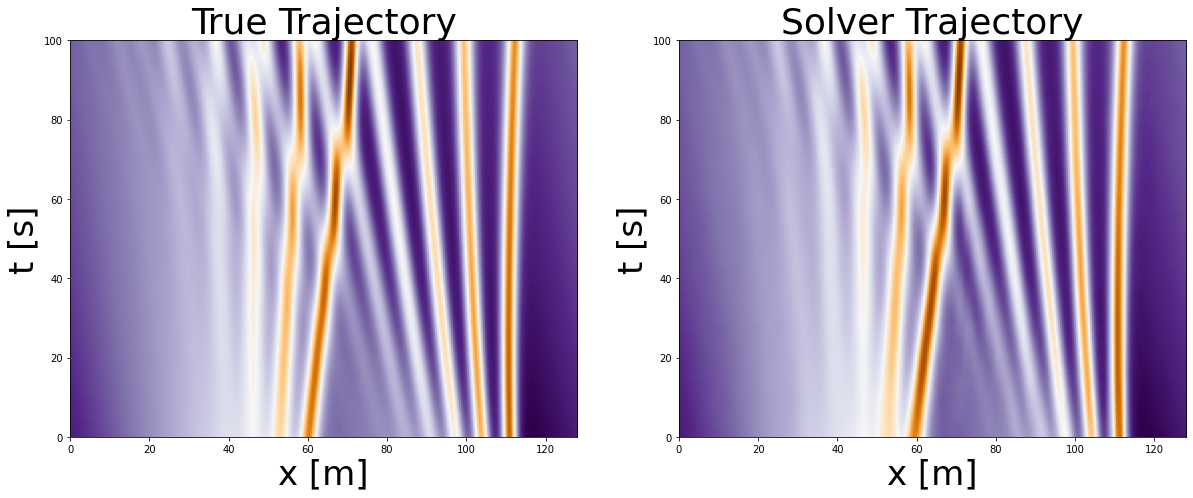

In [ ]:
#Plot True trajectory: produced by a numerical solver
# and Solver trajectory: produced by our NN
L=128
T=100
f, axarr = plt.subplots(1,2, figsize=(20,20))
axarr[0].set_title('True Trajectory', fontsize=36)
axarr[1].set_title('Solver Trajectory', fontsize=36)
axarr[0].imshow(true_trajectory, extent=[0,L,0,T], cmap='PuOr_r')
axarr[1].imshow(trajectory, extent=[0,L,0,T], cmap='PuOr_r')
axarr[0].set_xlabel('x [m]', fontsize=34)
axarr[0].set_ylabel('t [s]', fontsize=34)
axarr[1].set_xlabel('x [m]', fontsize=34)
axarr[1].set_ylabel('t [s]', fontsize=34);

Execute the above 2 cells multiple times: the trajectory will change as we are using next function on the test dataset. You can see how well the model performs on different initial conditions (different wave formations).

As you can see after visual inspection our trained NN performs quite well on multiple initial conditions of the given PDE. Often in the literature this is highlighted as the benefit of Neural PDE Solvers --> improved generalizability accross multiple initial conditions. However, I would take this with a bit of a grain of salt as in order to train this network we first actually had to use a numerical solver that generated all the trajectories for these different initial conditions.  

### Zero-Shot Resolution

We trained our network on 256 resolution of the spatial domain:

In [ ]:
u, _, _ = next(iter(train_loader))
print('Spatial resolution of training data: {}'.format(u[0].shape[1]))
print('Time resoltuion of training data: {}'.format(u[0].shape[0]))

Spatial resolution of training data: 256
Time resoltuion of training data: 140


Now let's see what happens if we input to our network a higher resolution, let's say **512**. We are going to keep the temporal resolution unchanged, 140

First let's generate such initial data and true trajectory by a numerical solver

*We changed the parameter N --> it defines the resolution of our 128 length rod*

In [ ]:
# Set the size of the domain, and create the discretized grid.
np.random.seed(3)
L = 128
N = 2**9
x = np.linspace(0, (1-1.0/N)*L, N)

# Set the tolerance of the solver
tol = 1e-6

# Set the initial conditions.
u0 = initial_conditions(x, L)

# Set the time sample grid.
T = 100.
t = np.linspace(0, T, 140)

# Compute the solution using kdv_pseudospectral as spatial solver
sol_ps_higher = solve_ivp(fun=kdv_pseudospectral,
                               t_span=[t[0], t[-1]],
                               y0=u0,
                               method='Radau',
                               t_eval=t,
                               args=(L,),
                               atol=tol,
                               rtol=tol)

true_trajectory_h = sol_ps_higher.y.T[::-1]
print('The spatial resolution {} and the temporal {}'.format(true_trajectory_h.shape[1],true_trajectory_h.shape[0]))

The spatial resolution 512 and the temporal 140


Now let's use the first 20 timepoints as input to our network, and allow the network to predict the latter.

In [ ]:
start = 0
end_time = 20
trajectory_h = np.zeros(shape=(140,512))
correct_dir = np.flipud(true_trajectory_h)
trajectory_h[start:end_time,:] = correct_dir[start:end_time,:]

#take initial datapoints and generate the whole trajectory
with torch.no_grad():
  while start < 120:
    data = torch.from_numpy(correct_dir[start:end_time,:]).to(device)
    data = torch.unsqueeze(data, 0)
    data = data.permute(0,2,1)
    pred = model(data.float())
    start += 20
    end_time += 20
    trajectory_h[start:end_time,:] = torch.squeeze(pred.permute(0,2,1)).cpu().detach().numpy()


trajectory_h = np.flipud(trajectory_h)

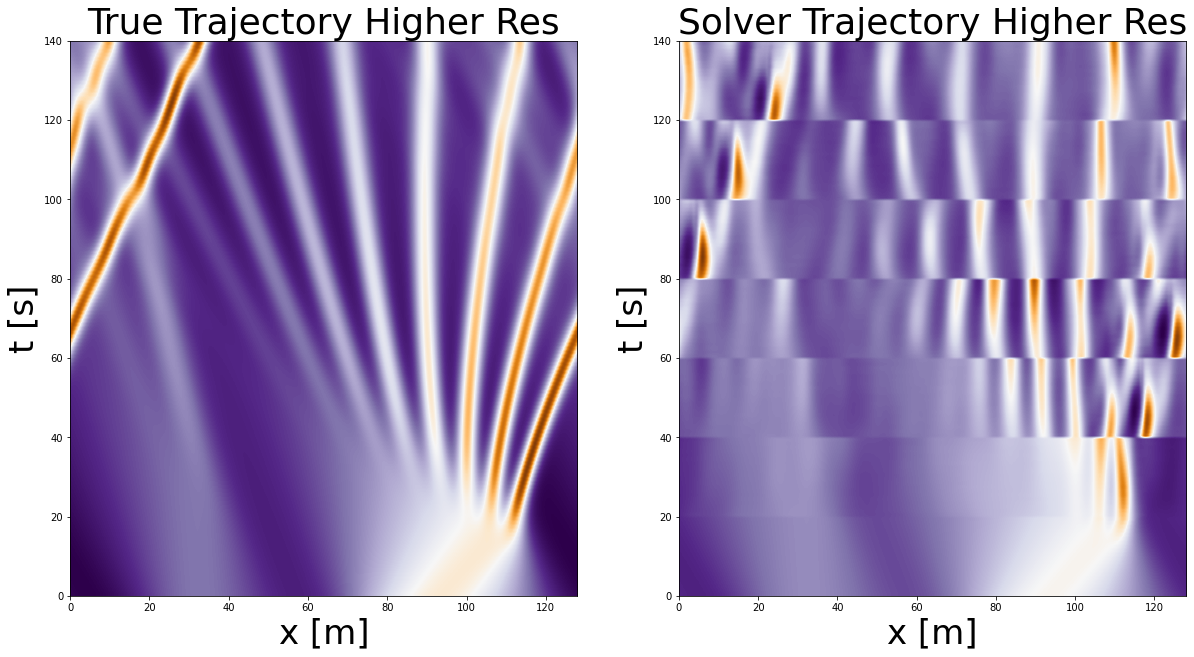

In [ ]:
#Let's plot the true and predicted trajectory
L=128
T=140
f, axarr = plt.subplots(1,2, figsize=(20,20))
axarr[0].set_title('True Trajectory Higher Res', fontsize=36)
axarr[1].set_title('Solver Trajectory Higher Res', fontsize=36)
axarr[0].imshow(true_trajectory_h, extent=[0,L,0,T], cmap='PuOr_r')
axarr[1].imshow(trajectory_h, extent=[0,L,0,T], cmap='PuOr_r')
axarr[0].set_xlabel('x [m]', fontsize=34)
axarr[0].set_ylabel('t [s]', fontsize=34)
axarr[1].set_xlabel('x [m]', fontsize=34)
axarr[1].set_ylabel('t [s]', fontsize=34);

As we can see our PDE Solver is able to take as input higher resolution and also output higher resolution. As such, it has the quality of being **resolution-invariant**.

In the same time we see that the output of our predictions isn't too accurate. One way how we can improve this is by adding two additional channels as input, the spatial and temporal resolutions (dx and dt). For further details see the [LPSDA paper](https://arxiv.org/abs/2202.07643)

## <font size="6" color="darkblue"> Fourier Filters compared to CNNs </font>

One of the reasons proposed by Li et al. why fourier filters are more suited for dynamical problems than CNNs is because filters in convolution neural networks are usually local, while fourier filters are global sinusoidal functions. As such, CNNs are better in capturing local patterns such as edges and shapes, while fourier filters are better for representing continous functions (see image below).


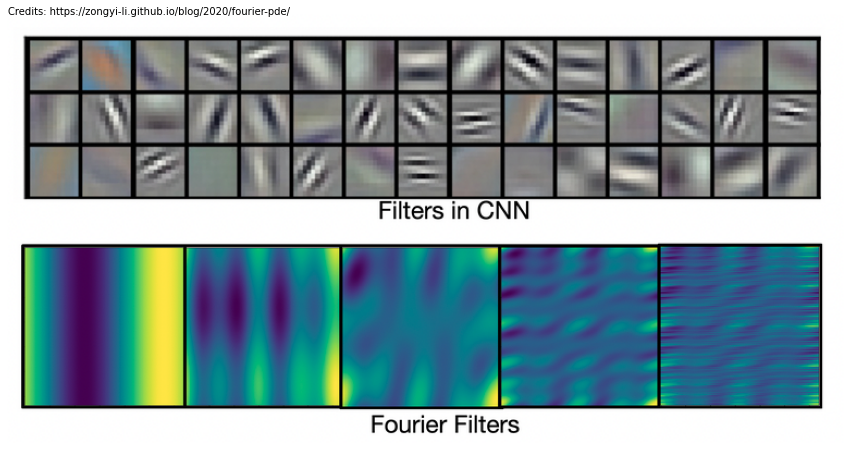

In [ ]:
img_fourier = mpimg.imread('/content/DL2_Tutorial2/images/filters.png')
caption = "Credits: https://zongyi-li.github.io/blog/2020/fourier-pde/"
plt.figure(figsize=(15, 10))
plt.imshow(img_fourier)
plt.text(0, 0, caption, ha='left', fontsize=10)
plt.axis('off');

## <font size="6" color="darkblue">Related Work</font>

Now, after reading all of this you might be wondering: *how did they think of fourier filter in the first place?*

Truth be told, the authors actually first tried multiple different neural operators: [graph NO](https://arxiv.org/abs/2003.03485), [multipole graph NO](https://arxiv.org/abs/2006.09535), [low-rank NO](https://arxiv.org/abs/2108.08481), and from all of these the fourier NO turned out to be the most promising. However, it is quite interesting to think why so. Actually in math Fourier transform is often used to solve differential equations as it can reformulate them as problems that are easier to solve. Hence, intuitively it makes sense that also for neural networks --> operating on a problem in fourier space might be easier.

The paper, based on which this tutorial was created, was published in ICLR 2020. Since then more researchers have built upon this topic. Here I would like to highlight some of them:
- [Message Passing](https://arxiv.org/abs/2202.03376): uses a different underlying architecture but has nice tricks for longer/more stable rollouts
- [LEADS](https://arxiv.org/abs/2106.04546): Model generalization across environements
- [Factorized FNO](https://arxiv.org/abs/2111.13802): this paper implements well known tricks from deep learning in order to create deeper FNO architectures
- [Lie Point Symmetry](https://arxiv.org/abs/2202.07643): this paper uses pre-existing knowledge of PDE symmetries to improve generalizability and rollouts


## <font size="6" color="darkblue">Investigate Yourself</font>

I hope that after this tutorial you have gotten more curious about modelling dynamical systems, as well as we have broaden your perspective on deep learning possibilities!

Below are a few things that you can try to change in the code to play around with it:
- Simply play around with the parameters: number of modes to keep, hidden layer size, the depth of your network etc. How does that affect your output?
- Implement a CNN, how does it perform in comparison?
- What happens for very long rollouts?
- How does the model trained on KdV perform on a different PDE? Is it able to generlize?
- We were working on a 1d problem, can you adjust it to 2d?


## <font size="7" color="darkblue">Acknowledgements</font>

This tutorial was inspired/based upon on the following great resources:
- [Z.Li Blogpost](https://zongyi-li.github.io/blog/2020/fourier-pde/)
- [J.Brandsetter github](https://github.com/brandstetter-johannes/LPSDA)